# TME7 : Approche par modèle de substitution

Sofia Borchani (21212080)
Nour Bouchouchi (28600211)

In [1]:
from sklearn import datasets
import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import combinations


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


## Construction de règles contre-factuelles

1. On choisit le dataset iris de sklearn et on le sépare en une base d’apprentissage et une base de test.

In [2]:
iris = datasets.load_iris()

X = iris.data 
y = iris.target  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = iris.feature_names  
target_names = iris.target_names  


2. On construit un arbre de décision avec la base d'apprentissage.

In [3]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
arbre = clf.tree_

In [4]:
list(target_names)

['setosa', 'versicolor', 'virginica']

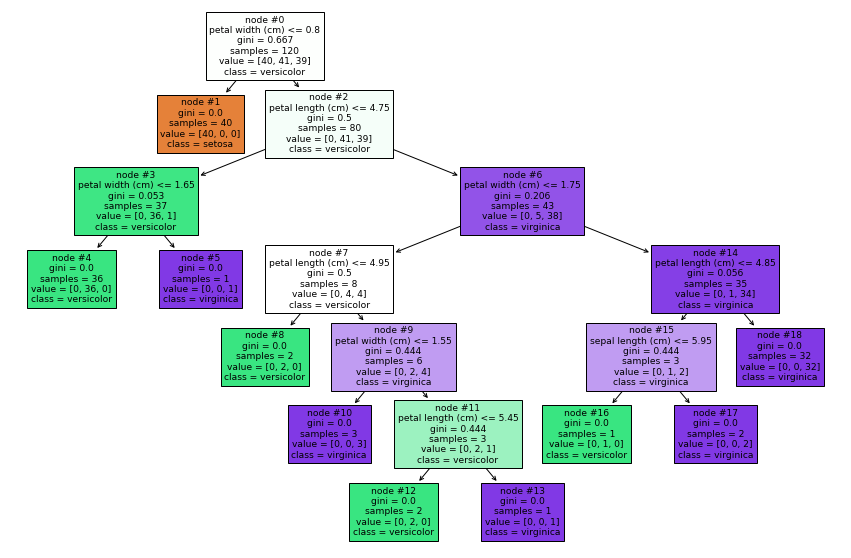

In [5]:
plt.figure(figsize=(15, 10))  
tree.plot_tree(clf, feature_names=feature_names, class_names=list(target_names), label='all', node_ids=True, filled=True)
plt.show()

3. On choisit un exemple de la base comme exemple de référence x. On le classe avec l’arbre de
décision puis on affiche la règle activée pour son classement.

In [6]:
idx = 0
x =  X_test[idx]
yhat = clf.predict([x])

In [7]:
data = {feature: value for feature, value in zip(feature_names, x)}
df = pd.DataFrame([data])
df['predicted label'] = yhat
df['predicted class'] = target_names[yhat][0]
df['true label'] = y_test[idx]
df['true class'] = target_names[y_test[idx]]

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),predicted label,predicted class,true label,true class
0,6.1,2.8,4.7,1.2,1,versicolor,1,versicolor


In [8]:
def predict_to_xai(clf, x, feature_names, target_names):
    decision_path = clf.decision_path([x]) # 0 si règle vérifiée et 1 sinon (pour chaque règle)

    tree_structure = clf.tree_
    
    node_indices = decision_path.indices # indices des règles qu'on parcourt jusqu'à une feuillle 
    for node_idx in node_indices:
        val_node = tree_structure.feature[node_idx] 
        if val_node != -2: #vaut -2 si on se trouve dans une feuille
            feature_name = feature_names[val_node]
            threshold = tree_structure.threshold[node_idx]
            decision = f"({node_idx}) {feature_name} <= {threshold:.2f} : {x[val_node] <= threshold}"
            print(decision)
        else : 
            predicted_class = clf.predict([x])[0]
            print(f"Predicted Class: {target_names[predicted_class]}")    
    return 

In [9]:
predict_to_xai(clf, x, feature_names, target_names)

(0) petal width (cm) <= 0.80 : False
(2) petal length (cm) <= 4.75 : True
(3) petal width (cm) <= 1.65 : True
Predicted Class: versicolor


4. On affiche toutes les règles contre-factuelles r′ ainsi que nr′ leur nombre de tests invalidés pour x.

In [10]:
def count_invalid_test(path, x, clf, feature_names):
    tree_structure = clf.tree_
    cpt = 0
    liste = []

    for i in range(len(path)-1) : 
        node_idx = path[i]
        next_node_idx = path[i+1]
        
        val_node = tree_structure.feature[node_idx] 

        threshold = tree_structure.threshold[node_idx]

        goes_left = (next_node_idx==node_idx+1)
        if (x[val_node] <= threshold) !=  goes_left:
            cpt+=1
            if goes_left : 
                liste.append(f" {feature_names[val_node]} <= {threshold:.2f}")
            else : 
                liste.append(f" {feature_names[val_node]} > {threshold:.2f}")

    return cpt, liste

In [11]:
def get_all_paths_counterfactuel(clf, x, yhat, feature_names, node=0, current_path=None, all_paths=None):
    if current_path is None:
        current_path = []
    current_path.append(node)

    tree = clf.tree_

    if all_paths is None:
        all_paths = []

    if tree.children_left[node] == tree.children_right[node] :
        pred = clf.classes_[np.argmax(tree.value[node])]
        if pred != yhat :
            cpt, liste = count_invalid_test(current_path, x, clf, feature_names)
            all_paths.append( (list(current_path), pred, cpt, liste))
    else:
        get_all_paths_counterfactuel(clf, x, yhat, feature_names, tree.children_left[node], list(current_path), all_paths)
        get_all_paths_counterfactuel(clf, x, yhat, feature_names, tree.children_right[node], list(current_path), all_paths)

    return all_paths

paths = get_all_paths_counterfactuel(clf, x, yhat, feature_names)

for path in paths:
    print(f"Chemin : {path[0]}")
    print(f"--> prediction : {path[1]}")
    print(f"--> nr' : {path[2]}\n")



Chemin : [0, 1]
--> prediction : 0
--> nr' : 1

Chemin : [0, 2, 3, 5]
--> prediction : 2
--> nr' : 1

Chemin : [0, 2, 6, 7, 9, 10]
--> prediction : 2
--> nr' : 2

Chemin : [0, 2, 6, 7, 9, 11, 13]
--> prediction : 2
--> nr' : 4

Chemin : [0, 2, 6, 14, 15, 17]
--> prediction : 2
--> nr' : 2

Chemin : [0, 2, 6, 14, 18]
--> prediction : 2
--> nr' : 3



5. On propose une explication pour la classification de x par l’arbre de décision.

Parmi les chemins contre-factuels possibles on prend celui pour lequel nr' est minimal. On choisi alors le chemin [0, 1] ce qui nous permet de donner l'explication suivante :  
si petal length (cm) <= 2.45 alors classe 1 (setosa).
  
On aurait également pu choisi l'explication avec le chemin [0,2,3,5] pour lequel nr' est également égal à 2. L'explication serait alors :  
si petal width (cm) > 1.65 alors classe 2 (virginica).

6. On propose une méthode pour présenter à l’utilisateur l’explication fournie à la question précédente.

Parmi les chemins contre-factuels proposés précédemment, on en prend un pour lequel nr' est minimal. On donne ensuite les nr' features qu'il faudrait modifier pour obtenir une autre prédiction.


In [12]:
def explain(clf, x, yhat): 
    paths = get_all_paths_counterfactuel(clf, x, yhat, feature_names)
    min_value = min(item[2] for item in paths)
    path, pred, nrprim, liste = [item for item in paths if item[2] == min_value][0]
    print(f"On propose une explication pour laquelle il faut changer {nrprim} feature(s) pour obtenir une autre prédiction : ")
    for l in liste : 
        print(f"   --> changer :{l}")
    return 

explain(clf, x, yhat)


On propose une explication pour laquelle il faut changer 1 feature(s) pour obtenir une autre prédiction : 
   --> changer : petal width (cm) <= 0.80


## Génération de base d'apprentissage et d'explications

In [13]:
np.random.seed(0)

1. En s'inspirant de l'apporche LORE, à partir d'un classifieur f et d'un exemple de référence x, on cherche à générer une base d'apprentissage pour consruire un modèle de substitution.

In [14]:
def cross_over(x1, x2):
    """ croisement 2-points : tirage al´eatoire de 2 attributs entre lesquels tous les attributs seront croisées"""
    att1, att2 = np.random.choice(x1.size, size=2, replace=False)
    
    if att1 < att2:
        new_x1 = np.concatenate((x1[:att1], x2[att1:att2], x1[att2:]))
        new_x2 = np.concatenate((x2[:att1], x1[att1:att2], x2[att2:]))
    else:
        new_x1 = np.concatenate((x1[:att2], x2[att2:att1], x1[att1:]))
        new_x2 = np.concatenate((x2[:att2], x1[att2:att1], x2[att1:]))
    
    return new_x1, new_x2

In [15]:
def mutation(x, noise):
    """ tirage aléatoire d’un attribut : la valeur de remplacement est tirée aléatoirement suivant la distribution des valeurs dans l’ensemble test """
    att = np.random.choice(x.size)
    new_val = x[att] + np.random.normal(0, noise)
    x[att] = new_val
    return x

In [16]:
def generer_donnees_substitution(clf, exemple_reference, positive_examples=True, nb_ex=50, prob_cross_over=0.2, prob_mutation=0.3, noise=0.5):
    population = np.tile(exemple_reference, (nb_ex, 1))
    classe_x = clf.predict([exemple_reference])[0]
    exemples = [] #liste des exemples de la classe souhaités 

    # Tant que l'on n'a pas atteint le nombre d'exemples souhaités dans la classe voulue (positive ou negative)
    while len(exemples)<nb_ex :
        # On modifie chaque exemple par mutation ou ou cross-over
        for i in range(nb_ex): 
            if np.random.rand() < prob_mutation : 
                population[i] = mutation(exemple_reference, noise)

            if np.random.rand() < prob_cross_over:
                j = (i+1)%nb_ex  
                population[i], population[j] = cross_over(population[i], population[j])

            # On ajoute l'exemple généré à la liste résultats s'il est de la classe souhaitée et est différent des autres exemples générés
            class_ex = clf.predict([population[i]])[0]
            if (class_ex == classe_x) == positive_examples and list(population[i]) not in exemples and not np.array_equal(population[i], exemple_reference):  
                exemples.append((population[i], class_ex))

    return exemples

In [17]:
# Création de la base d'apprentissage Xx avec des exemples positifs et négatifs
instance = X_test[0]

positive_examples = generer_donnees_substitution(clf, instance, positive_examples=True)
negative_examples = generer_donnees_substitution(clf, instance, positive_examples=False)
Xx = positive_examples+negative_examples

In [18]:
X_g, y_g = zip(*Xx)
X_g = np.array(X_g)
y_g = np.array(y_g)

2. On combine la fonction précédente avec ce que l'on a écrit dans l’exercice précédent pour écrire un programme de génération d’explications de la classification par f pour les exemples de la base de test.

On doit apprendre un arbre de décision g à partir de notre base d'apprentissage générée dans le voisinage de Xx. 

In [19]:
clf_g = DecisionTreeClassifier()
clf_g.fit(X_g, y_g)
arbre = clf_g.tree_

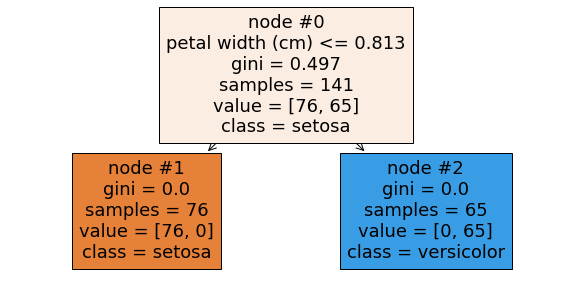

In [20]:
plt.figure(figsize=(10, 5)) 
tree.plot_tree(clf_g, feature_names=feature_names, class_names=list(target_names), label='all', node_ids=True, filled=True)
plt.show()

On peut noter que dans nos exemples générés on ne retrouve que 2 des 3 classes existantes dans le dataset. Cela s'explique par le fait que cette troisième classe possède peut-être des attributs très différents de la classe initiale de notre x et ne se trouve donc pas dans son voisinage contrairement à l'autre classe adverse présente. L'explication va donc se concentrer sur l'ambigüité possible entre la classe de x prédite par f et la classe des exemples proches de x.


La prédiction que faisait f était la suivante : 

In [21]:
y_f = clf.predict([instance])[0]
print("Classe de x selon f : ", target_names[y_f])

Classe de x selon f :  setosa


Le prédiction selon g est : 

In [22]:
y_g = clf_g.predict([instance])[0]
print("Classe de x selon g : ", target_names[y_g])

Classe de x selon g :  setosa


In [23]:
explain(clf_g, instance, y_f)


On propose une explication pour laquelle il faut changer 1 feature(s) pour obtenir une autre prédiction : 
   --> changer : petal width (cm) > 0.81


## Expérimentations

### Breast cancer dataset

On télécharge tout d'abord le dataset breast cancer qui contient 30 attributs et on le sépare entre ensemble de train et de test.

In [24]:
from sklearn.datasets import load_breast_cancer
np.random.seed(42)

In [25]:
bc = load_breast_cancer()
X_bc = bc.data
y_bc = bc.target  

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_bc, y_bc, test_size=0.2, random_state=42)
feature_names = list(bc.feature_names  )
target_names = list(bc.target_names )

On commence par entraîner notre classifieur f 

In [27]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)


DecisionTreeClassifier()

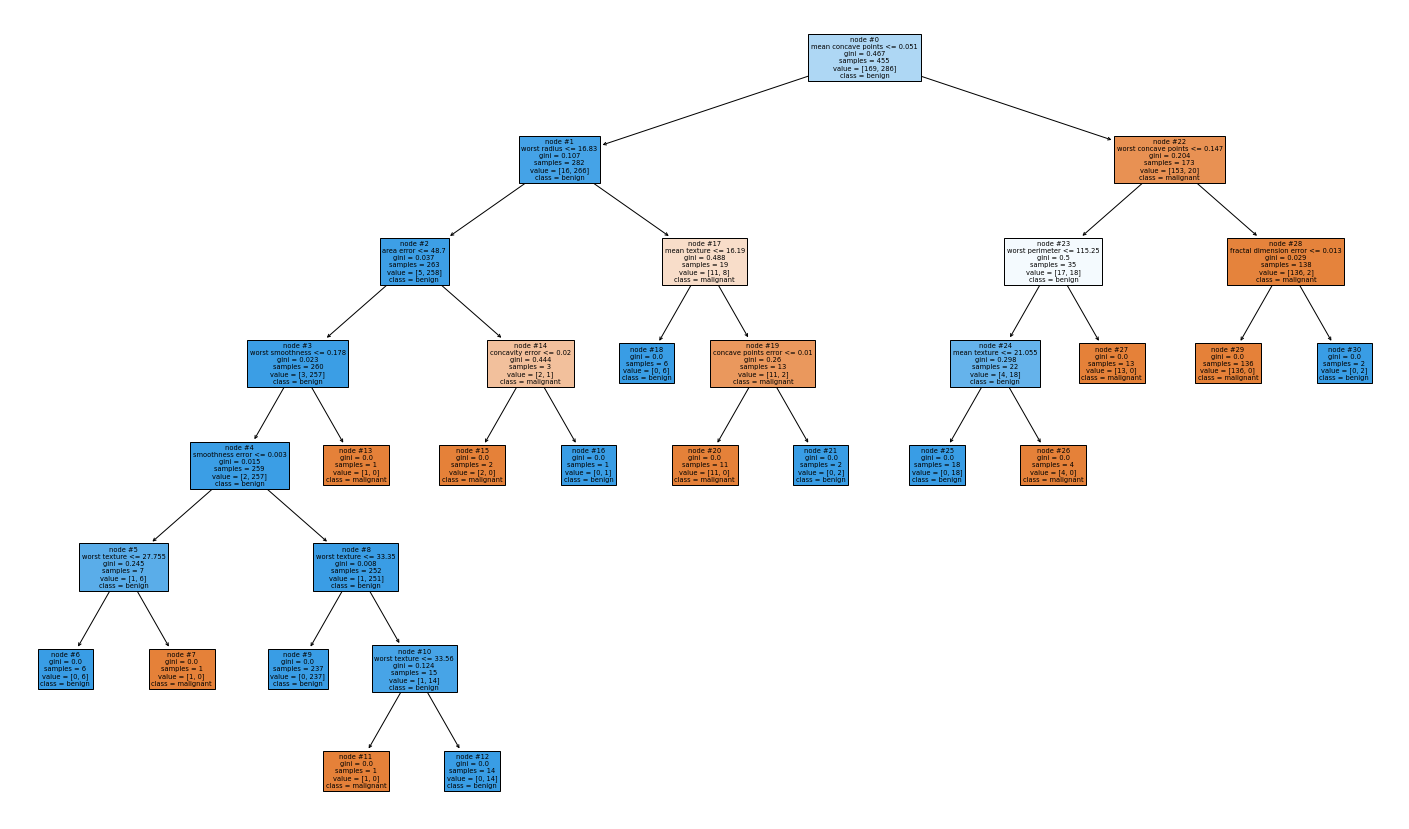

In [28]:
plt.figure(figsize=(25, 15)) 
tree.plot_tree(clf, feature_names=feature_names, class_names=target_names, label='all', node_ids=True, filled=True)
plt.show()

On génère ensuite des exemples pour expliquer un exemple de la base de test.  

In [29]:
instance = X_test[0]

positive_examples = generer_donnees_substitution(clf, instance, positive_examples=True)
negative_examples = generer_donnees_substitution(clf, instance, positive_examples=False)
Xx = positive_examples+negative_examples

X_g, y_g = zip(*Xx)

X_g = np.array(X_g)
y_g = np.array(y_g)

On peut ensuite entraîner un arbre de décision sur cette base générée puis expliquer la prédiction grâce à celui-ci. 

In [30]:
clf_g = DecisionTreeClassifier()
clf_g.fit(X_g, y_g)
arbre = clf_g.tree_

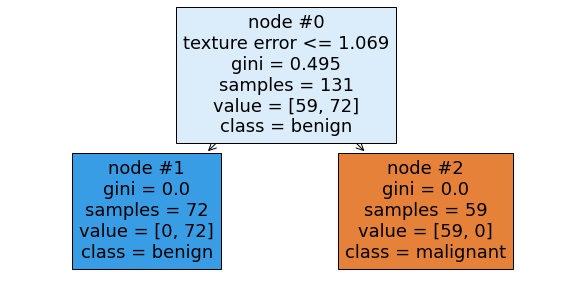

In [31]:
plt.figure(figsize=(10, 5)) 
tree.plot_tree(clf_g, feature_names=feature_names, class_names=list(target_names), label='all', node_ids=True, filled=True)
plt.show()

In [32]:
y_f = clf.predict([instance])[0]
print("Classe de x selon f : ", y_f)

y_g = clf_g.predict([instance])[0]
print("\nClasse de x selon g : ", y_g)
print()
explain(clf_g, instance, y_f)


Classe de x selon f :  0

Classe de x selon g :  0

On propose une explication pour laquelle il faut changer 1 feature(s) pour obtenir une autre prédiction : 
   --> changer : texture error <= 1.07


## Base de données générée manuellement pour laquelle il y a un chevauchement des classes 

On génère désormais une base de données half_moons pour laquelle les classes se chevauchent. On génère des données n'ayant que deux attributs puisqu'on s'intéresse ici à la problématique du chevauchement des classes. Les cross-over n'auront donc ici aucun effet lors de la génération de données dans le voisinage de x. 

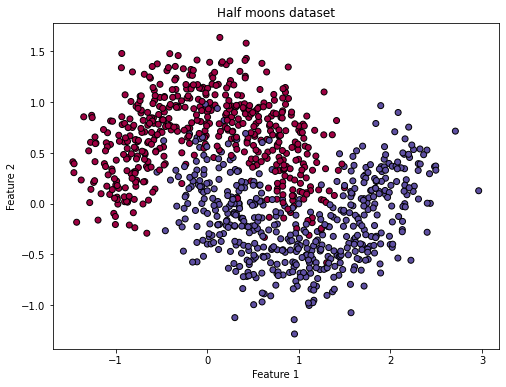

In [33]:
X,y = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.25, random_state=None)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, edgecolors='k')
plt.title('Half moons dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = ["feature_1", "feature_2"]
target_names = ["class_1", "class2_2"]

In [35]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

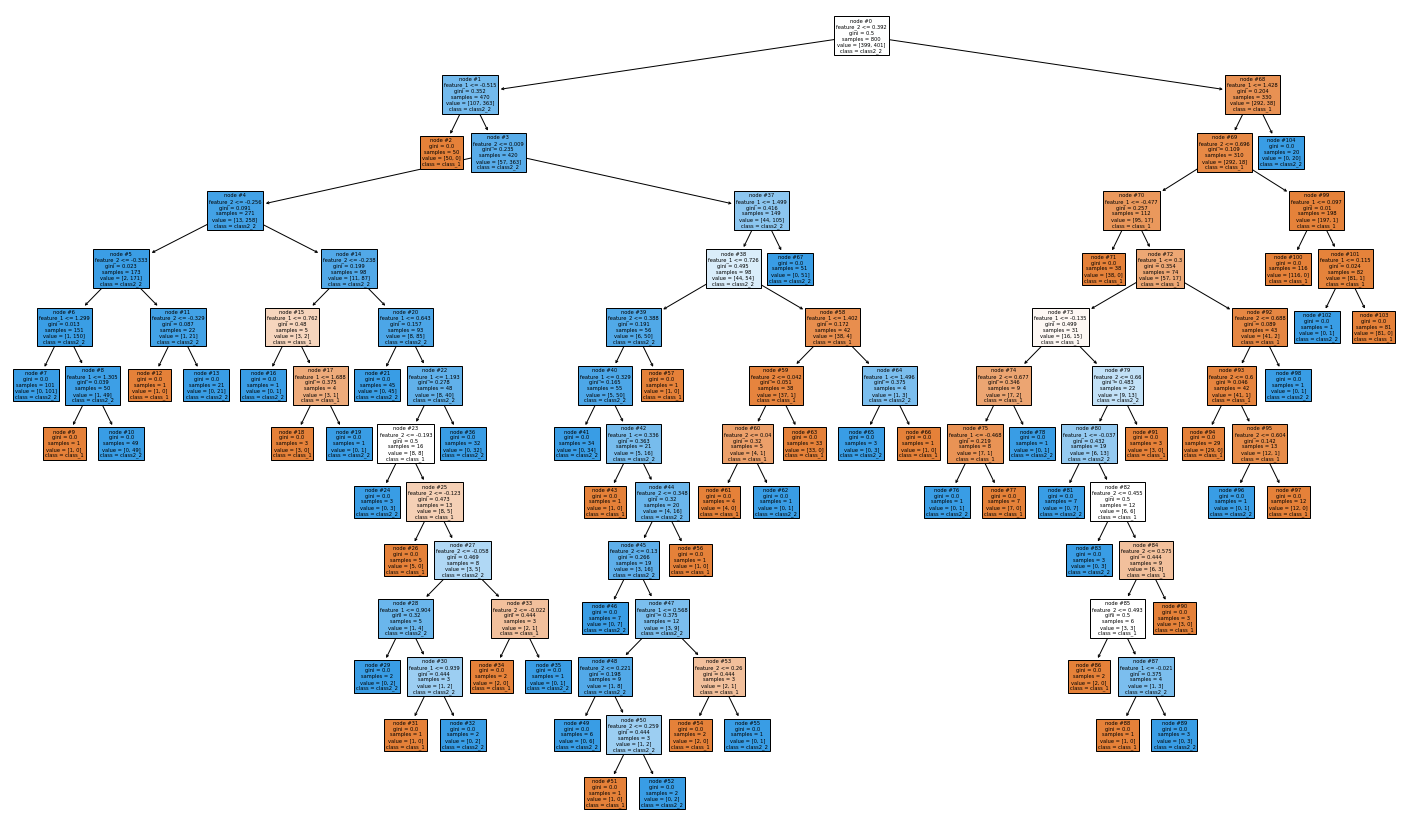

In [36]:
plt.figure(figsize=(25, 15)) 
tree.plot_tree(clf, feature_names=feature_names, class_names=target_names, label='all', node_ids=True, filled=True)
plt.show()

In [37]:
instance = X_test[5]

positive_examples = generer_donnees_substitution(clf, instance, positive_examples=True)
negative_examples = generer_donnees_substitution(clf, instance, positive_examples=False)
Xx = positive_examples+negative_examples

X_g, y_g = zip(*Xx)

X_g = np.array(X_g)
y_g = np.array(y_g)

In [38]:
clf_g = DecisionTreeClassifier()
clf_g.fit(X_g, y_g)
arbre = clf_g.tree_

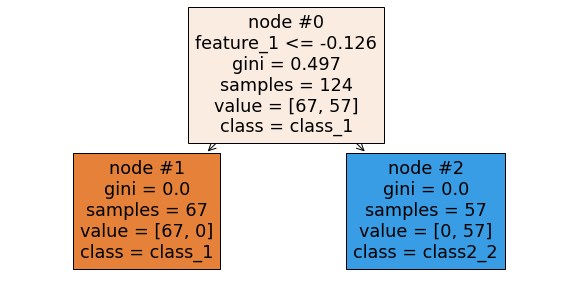

In [39]:
plt.figure(figsize=(10, 5)) 
tree.plot_tree(clf_g, feature_names=feature_names, class_names=list(target_names), label='all', node_ids=True, filled=True)
plt.show()

In [40]:
y_f = clf.predict([instance])[0]
print("Classe de x selon f : ", y_f)

y_g = clf_g.predict([instance])[0]
print("\nClasse de x selon g : ", y_g)
print()
explain(clf_g, instance, y_f)


Classe de x selon f :  1

Classe de x selon g :  1

On propose une explication pour laquelle il faut changer 1 feature(s) pour obtenir une autre prédiction : 
   --> changer : feature_1 <= -0.13
